In [169]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

import pickle
import os
import sys
import glob
from collections import OrderedDict
from tqdm import tqdm

In [170]:
sys.path.append('../../')
import compute_preprocessing

In [171]:
def convert_input_for_ann(times, q, chi1, theta1):
    X = []
    for _q, _chi1, _theta1 in zip(q, chi1, theta1):
        for t in times:
            X.append([t, _q, _chi1, _theta1])
    X = np.asarray(X)
    return X

In [172]:
def compute_model_input(times, q, chi1, theta1):
    
    # broadcast and stack with times array
    output = np.ones(shape=(times.shape[0], 1))
    output = output * np.array([q, chi1, theta1])
    
    output = np.column_stack((times, output))
    
    return output

In [173]:
import tensorflow as tf

In [174]:
import pugna.layers
import pugna.activations

In [175]:
# https://datascience.stackexchange.com/questions/58884/how-to-create-custom-activation-functions-in-keras-tensorflow
from tensorflow.keras.utils import get_custom_objects
get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})

In [176]:
def preload_amp(data_dir):

    pkl_filename = os.path.join(data_dir, "pre_processing_1e3/times_scaler.pkl")
    with open(pkl_filename, 'rb') as file:
        times_scaler = pickle.load(file)
    
    
    times = np.load(os.path.join(data_dir, "training_data_1e3/times.npy"))
    
    times_scaled = times_scaler.transform(times[:, np.newaxis])[:, 0]
    
    ys_raw = np.load(os.path.join(data_dir, "training_data_1e3/amplitude.npy"))
    ys_processing_params = np.load(os.path.join(data_dir, "pre_processing_1e3/amp_preprocessing_params.npz"))
    
    ys = compute_preprocessing.apply_pre_process_forward(ys_raw, ys_processing_params['mean'], ys_processing_params['max'])
    
    coords = np.load(os.path.join(data_dir, "training_data_1e3/coords.npy"))
#     X = convert_input_for_ann(times_scaled, coords[0], coords[1], coords[2])

    

                     
    return times, times_scaled, coords, ys_raw, ys, ys_processing_params

In [177]:
mfiles = sorted(glob.glob("00*/model*"))
print(mfiles)

models = OrderedDict()
for mfile in mfiles:
    key = mfile.split('/')[0]
    models[key] = tf.keras.models.load_model(mfile,
                                       custom_objects={'Mscale': pugna.layers.Mscale,
                                                       'Activation':tf.keras.layers.Activation,
                                                       'name':pugna.activations.s2relu})

['001/model.h5', '002/model.h5', '003/model.h5', '004/model.h5', '005/model.h5', '006/model.h5']


In [178]:
models.keys()

odict_keys(['001', '002', '003', '004', '005', '006'])

In [179]:
data_dir="/home/sebastian.khan/git/stk/ml/waveforms/april2021/3d-precession/upscale/"

In [180]:
times, times_scaled, coords, ys_raw, ys, ys_processing_params = preload_amp(data_dir=data_dir)

In [181]:
coords.shape

(3, 1000)

In [182]:
ys.shape

(1000, 1099)

In [183]:
times

array([-499.50529851, -499.00529851, -498.50529851, ...,   48.49470149,
         48.99470149,   49.49470149])

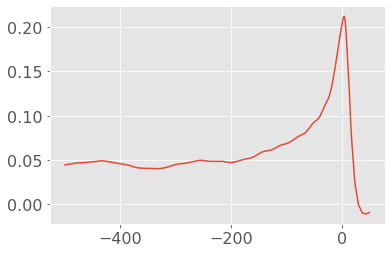

In [184]:
plt.figure()
plt.plot(times, ys[0])

In [ ]:
def compare_models(index, ys_raw, preprocessing_params, coords, times_scaled, times, models):
    q = np.around(coords[0,index], 3)
    chi1 = np.around(coords[1,index], 3)
    theta1 = np.around(coords[2,index], 3)
    
    title = f"q = {q}, chi1 = {chi1}, theta1 = {theta1}"
    
    Xhat = compute_model_input(times_scaled, q, chi1, theta1)
    yhats = OrderedDict()
    for k, v in models.items():
        yhat = models[k].predict(Xhat).T
        
        yhats[k] = compute_preprocessing.apply_pre_process_reverse(yhat, preprocessing_params['mean'], preprocessing_params['max'])[0]
        
        
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 1, 1)
    plt.plot(times, ys_raw[index], label='data')
    for k, v in yhats.items():
        plt.plot(times, v, label=k)
#     plt.xlim(-200, 50)
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.subplot(2, 1, 2)
    for k, v in yhats.items():
        plt.plot(times, 100*(ys_raw[index]-v)/ys_raw[index], label=f"% (data-{k})")
#     plt.xlim(-200, 50)
#     plt.ylim(-10, 10)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
np.where((coords[1] > 0.98) & (coords[2] > 1.3))

In [ ]:
np.where((coords[1] > 0.6) & (coords[2] > 1.3) & (coords[2] < 1.6))

In [209]:
models

OrderedDict([('001',
              <tensorflow.python.keras.engine.sequential.Sequential at 0x7f78f4485990>),
             ('002',
              <tensorflow.python.keras.engine.sequential.Sequential at 0x7f78f44d2e50>),
             ('003',
              <tensorflow.python.keras.engine.sequential.Sequential at 0x7f78f44c9dd0>),
             ('004',
              <tensorflow.python.keras.engine.sequential.Sequential at 0x7f78f40a8490>),
             ('005',
              <tensorflow.python.keras.engine.sequential.Sequential at 0x7f78f448be50>),
             ('006',
              <tensorflow.python.keras.engine.sequential.Sequential at 0x7f78e3e88950>)])

In [210]:
models_subset = {k: models[k] for k in ('003', '005')}

In [213]:
models_subset['005'].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mscale_12 (Mscale)           (None, 1000)              5000      
_________________________________________________________________
activation_2 (Activation)    (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 1000)              1001000   
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1001      
Total params: 2,008,001
Trainable params: 2,008,001
Non-trainable params: 0
_________________________________________________________________


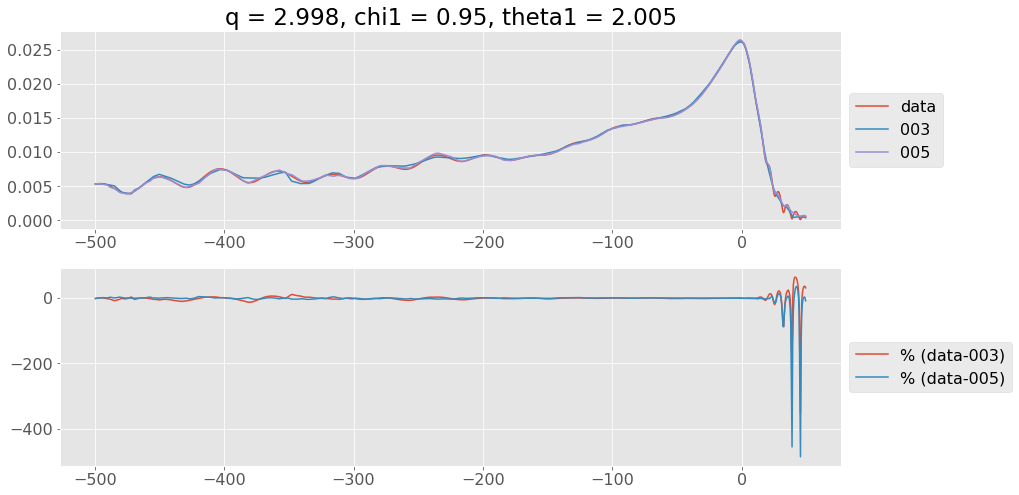

In [212]:
# compare_models(index=789, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)
compare_models(index=789, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models_subset)

In [189]:
Xhat = convert_input_for_ann(times_scaled, *coords[:, :10])
# Xhat = convert_input_for_ann(times_scaled, *coords)
yhat = models['001'].predict(Xhat).T

In [190]:
yhat.shape

(1, 10990)

In [192]:
def compute_errors(ys_raw, preprocessing_params, coords, times_scaled, times, models):
    
    n_cases = coords.shape[1]
#     max_loop = 10
    max_loop = n_cases
    
    yhats = OrderedDict()
    errors = OrderedDict()
    for k, v in models.items():
        
        if os.path.exists(f"errors_{k}.npy"):
            print("ALREADY CALCULATED LOADING DATA")
            errors[k] = np.load(f"errors_{k}.npy")
            continue
        
        print(f"working model: {k}")
        yhats[k] = np.zeros(shape=(n_cases, times_scaled.shape[0]))
        errors[k] = np.zeros(shape=(max_loop))

#         for index in tqdm(range(n_cases)):
        for index in tqdm(range(max_loop)):

            q = coords[0,index]
            chi1 = coords[1,index]
            theta1 = coords[2,index]

            Xhat = compute_model_input(times_scaled, q, chi1, theta1)
        
            yhat = models[k].predict(Xhat).T
            tt = compute_preprocessing.apply_pre_process_reverse(yhat, preprocessing_params['mean'], preprocessing_params['max'])[0]
            yhats[k][index] = tt
            
            errors[k][index] = np.max(100*(ys_raw[index]-yhats[k][index])/ys_raw[index])
            
        print("SAVING")
        np.save(f"errors_{k}.npy", errors[k])
        
    return errors

In [193]:
%%time
errors = compute_errors(ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)

  0%|          | 1/1000 [00:00<02:32,  6.54it/s]

working model: 001


  0%|          | 1/1000 [00:00<02:09,  7.72it/s]

SAVING
working model: 002


  0%|          | 1/1000 [00:00<01:58,  8.40it/s]

SAVING
working model: 003


  0%|          | 1/1000 [00:00<01:49,  9.12it/s]

SAVING
working model: 004


  0%|          | 0/1000 [00:00<?, ?it/s]

SAVING
working model: 005


  0%|          | 1/1000 [00:00<02:42,  6.13it/s]

SAVING
working model: 006


100%|██████████| 1000/1000 [02:59<00:00,  5.57it/s]


SAVING
CPU times: user 28min 50s, sys: 3min 15s, total: 32min 5s
Wall time: 12min 58s


In [194]:
errors['001'].shape

(1000,)

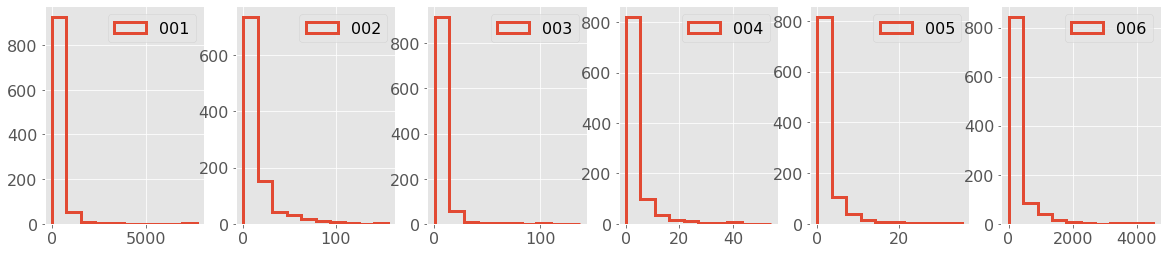

In [195]:
plt.figure(figsize=(20, 4))
for i,(k,v) in enumerate(errors.items()):
    plt.subplot(1, len(errors.keys()), i+1)
    plt.hist(np.abs(v), label=k, histtype='step', linewidth=3);
#     , density=True
    plt.legend()
# plt.xlim(0, 100)

In [198]:
max_idx = {}
for i,(k,v) in enumerate(errors.items()):
    max_value = np.max(np.abs(v))
    print(f"{k}: {max_value}")
    max_idx[k] = np.where(np.abs(v) == max_value)

001: 7689.454660328347
002: 157.05261407590345
003: 137.26752093728905
004: 53.9019324335192
005: 35.62019273554758
006: 4520.854091780358


In [200]:
max_idx

{'001': (array([82]),),
 '002': (array([826]),),
 '003': (array([665]),),
 '004': (array([82]),),
 '005': (array([789]),),
 '006': (array([361]),)}

Text(0, 0.5, '$\\theta_1$')

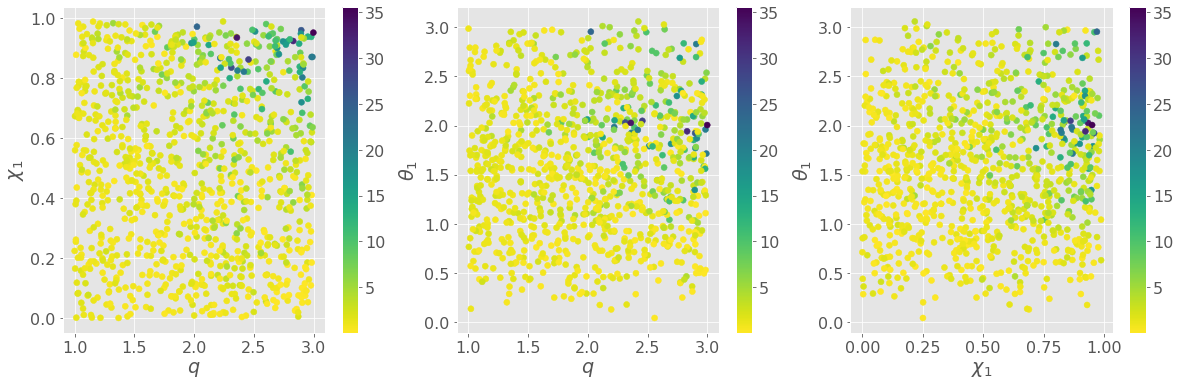

In [199]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.scatter(coords[0], coords[1], c=errors['005'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$q$')
plt.ylabel(r'$\chi_1$')
plt.subplot(1, 3, 2)
plt.scatter(coords[0], coords[2], c=errors['005'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$q$')
plt.ylabel(r'$\theta_1$')
plt.subplot(1, 3, 3)
plt.scatter(coords[1], coords[2], c=errors['005'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$\chi_1$')
plt.ylabel(r'$\theta_1$')